# Aspen modeling

The purpose of this notebook is to systematically callibrate and conduct sensitivities

#### Resources
* https://medium.com/eni-digitalks/optimize-process-simulation-with-python-aspen-integration-e343bbab1aa0
* https://github.com/edgarsmdn/Aspen_HYSYS_Python
* https://kitchingroup.cheme.cmu.edu/blog/2013/06/14/Running-Aspen-via-Python/

#### Instructions
* Go to customize tab in aspen 
* look at variable explorere to find the nodes you want to change

Equation for efficiency: 

$\eta = W_{out}/Q_{in} = W_{out}/(F_{salt}*\Delta H_{salt})$


In [1]:
#Import relevant packages

import openpyxl
import subprocess

import win32com.client as win32
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
#get current working directory
os.getcwd()

'C:\\Users\\MITEI_Athlete\\Desktop\\Serena_AspenModels\\Trombay_analysis\\Unit 5'

## Analysis 

In [3]:
#initialize output data df
output_var = pd.Index(['steam_eff','Qs','P_out_net','F_salt','deltaA','deltaB','deltaC','deltaD',
                       'Q1','Q2','Q3',
                       'flowsteamPeak','coal_steam_eff',
                       'target_pressure',
                        'HP_input_T_MS',
                       'HP_output_T_MS','HP_output_P_MS',
                       'IP_input_T_MS','IP_input_P_MS',
                       'LP_input_T_MS','LP_input_P_MS',
                       'LP_output_T_MS','LP_output_P_MS',
                       'LP_vaporfraction_MS',
                       
                       'HP_output_T_coal','HP_output_P_coal',
                       'IP_input_T_coal','IP_input_P_coal',
                       'LP_input_T_coal','LP_input_P_coal',
                       'LP_output_T_coal','LP_output_P_coal',
                       'LP_vaporfraction_coal',
                       'coal_power_net',
                       'flowsteam_calibrated','cold_salt_temp',
                       'steam_peak_temp'
                       
                      ])

## Coal plant 


* constant aux power included

$$\eta = W_{out} / Q_{in} $$



In [7]:
def coal_simulation(inputdata_df, output_df):
    #set the path
    path = 'C:\\Users\\MITEI_Athlete\\Desktop\\Serena_AspenModels\\Trombay_analysis\\Unit 5\\coal_plant\\rankine_supercritical_MS.apw'
    aspen = win32.gencache.EnsureDispatch('Apwn.Document')
    aspen.InitFromArchive2(path)

    #set columns to iterate over
    plant_list = inputdata_df.columns

    #for every plant type in the data inputs
    for plantID in plant_list:

        #get the target steam efficiency from the inputs
        target_steam_eff = inputdata_df.loc['steam_eff',plantID] 

       #SET VALUES
        #set the max and min steam flowrate for the design spec in aspen 
        #aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\DS-1\Input\LOWER").Value = inputdata_df.loc['F_steam',plantID]/2
        #aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\DS-1\Input\UPPER").Value = inputdata_df.loc['F_steam',plantID]*1.5

        #set the max and min LP output pressure
        aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\DS-1\Input\LOWER").Value = 0.0475 #0.0475 #corresponds to 35 C
        aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\DS-1\Input\UPPER").Value = 0.15

        #set the effciiency output
        aspen.Tree.FindNode("\Data\Flowsheeting Options\Design-Spec\DS-1\Input\EXPR2").Value = target_steam_eff
        #set the power tolerance to something (10 MW)
        aspen.Tree.FindNode("\Data\Flowsheeting Options\Design-Spec\DS-1\Input\TOL").Value = 0.001

        #seperate flow closed loop
        #set steam flow fixed
        aspen.Tree.FindNode("\Data\Streams\IN\Input\TOTFLOW\MIXED").Value = inputdata_df.loc['F_steam',plantID] 

        #main steam pressure
        aspen.Tree.FindNode("\Data\Streams\IN\Input\PRES\MIXED").Value = inputdata_df.loc['Pressure_steam',plantID]


        #set steam flow fixed
        aspen.Tree.FindNode("\Data\Streams\STREAM24\Input\TOTFLOW\MIXED").Value = inputdata_df.loc['F_steam',plantID] 

        #main steam temperature C
        aspen.Tree.FindNode("\Data\Blocks\BOILER\Input\TEMP").Value = inputdata_df.loc['Temperature_steam',plantID]

        #main steam pressure
        aspen.Tree.FindNode("\Data\Blocks\PUMP\Input\PRES").Value = inputdata_df.loc['Pressure_steam',plantID] 

        #IP steam temperature
        aspen.Tree.FindNode("\Data\Blocks\BOILER2\Input\TEMP").Value = inputdata_df.loc['Temperature_steam',plantID]

        #aux consumption 
        aspen.Tree.FindNode("\Data\Streams\AUX\Input\POWER").Value = inputdata_df.loc['P_aux_coal',plantID] #in MW

        #change the steam flow in the senstiivty range
        aspen.Tree.FindNode("\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Input\\LOWER\\#1").Value = inputdata_df.loc['F_steam',plantID] / 2
        aspen.Tree.FindNode("\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Input\\UPPER\\#1").Value = inputdata_df.loc['F_steam',plantID] * 1.5

        #RUN ASPEN MODEL
        aspen.Engine.Run2()

        #target_pres = 0
        lp_file = "\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Output\\SENSVAR2\\1\\"
        plant_sens_df = pd.DataFrame()
        #for each row in the table
        for row in np.arange(1,100):
            plant_sens_row = pd.DataFrame()
            #low pressure turbine output (sensitivity variable)
            flow = aspen.Tree.FindNode(lp_file+str(row)).Value
            #set in the df
            plant_sens_row['flow'] = [flow]
            #get the column value
            for col in np.arange(1,16):

                #name of the column (HEATIn etc)
                col_name = aspen.Tree.FindNode("\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Output\\VARID\\"+str(col)).Value
                value = aspen.Tree.FindNode("\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Output\\SENSVAR2\\"+str(col+1)+"\\"+str(row)).Value

                #set in the df 
                plant_sens_row[col_name]=[value]


            #append to df 
            plant_sens_df=plant_sens_df.append(plant_sens_row)

        #analyze the plant_sens_df efficiency
        #eff_round = round((plant_sens_df['W1']+plant_sens_df['W2']+plant_sens_df['W3'])/plant_sens_df['HEATIN'],4)
        
        #plant_sens_df['eff'] = (plant_sens_df['W1']+plant_sens_df['W2']+plant_sens_df['W3'])/plant_sens_df['HEATIN']
        plant_sens_df['eff'] = plant_sens_df['POUTNET']/plant_sens_df['HEATIN']


        #reset plant_sens_df temps are larger than 35
        # plant_sens_df =  plant_sens_df[plant_sens_df['LPTEMPO'] >= 35]

        target_power = (inputdata_df.loc['P_out',plantID] + inputdata_df.loc['P_aux_coal',plantID]  )*-1

        targets_df =   pd.DataFrame(plant_sens_df.iloc[np.argmin(abs(plant_sens_df['POUTNET']-target_power))]).T 

        #save the plant_sens_df to comb through
        plant_sens_df.to_excel(str(plantID)+'sensitivity'+'.xlsx')

        #take the last target row to the calibrated plant outputs, has highest steam flow rate
        plant_calibrated = targets_df[-1:]

        ## STORE RESULTS IN OUTPUT D

        output_df.loc['coal_steam_eff',plantID]=plant_calibrated['eff'][0]
        output_df.loc['target_pressure',plantID]=plant_calibrated['LPPRESO'][0]

        #HP output
        output_df.loc['HP_output_T_coal',plantID]= plant_calibrated['HPTEMP'][0]
        output_df.loc['HP_output_P_coal',plantID] = plant_calibrated['HPPRES'][0] 

        #IP input
        output_df.loc['IP_input_T_coal',plantID]= plant_calibrated['IPTEMP'][0]
        output_df.loc['IP_input_P_coal',plantID] = plant_calibrated['IPPRES'][0]

        #LP input (IP output)
        output_df.loc['LP_input_T_coal',plantID]= plant_calibrated['LPTEMPIN'][0]
        output_df.loc['LP_input_P_coal',plantID] = plant_calibrated['LPPRESIN'][0]

        #LP output
        output_df.loc['LP_output_T_coal',plantID]= plant_calibrated['LPTEMPO'][0]

        #print the plantID if the LP tempout is less than 35
        if plant_calibrated['LPTEMPO'][0] < 35: 
            print('LP tempout: ', plantID, plant_calibrated['LPTEMPO'][0])

        output_df.loc['LP_output_P_coal',plantID] = plant_calibrated['LPPRESO'][0]

        #vapor fraction out of LP turbine
        output_df.loc['LP_vaporfraction_coal',plantID] = plant_calibrated['LPVF'][0]

        #print the plantID if the LPVF less than 0.8
        if plant_calibrated['LPVF'][0] < 0.80: 
            print('LP VF: ', plantID, plant_calibrated['LPVF'][0])

        #gross power output
        output_df.loc['coal_power_net',plantID] = plant_calibrated['POUTNET'][0] #this is the work from the turbines and pump, no aux

        #steam flow calibrated
        output_df.loc['flowsteam_calibrated',plantID] = plant_calibrated['FSTEAM'][0]
        
    return output_df, plant_sens_df

In [8]:

def MS_TES_simulation(inputdata_df, output_df, peak_salt_temp):
    #molten salt TES path
    path = 'C:\\Users\\MITEI_Athlete\\Desktop\\Serena_AspenModels\\Trombay_analysis\\Unit 5\\MS_TES_standalone\\Molten_v4.apw'
    aspen = win32.gencache.EnsureDispatch('Apwn.Document')
    aspen.InitFromArchive2(path)

    #set columns to iterate over
    plant_list = inputdata_df.columns
    


    #for every plant type in the data inputs
    for plantID in plant_list:
        
        #set the temperature of salt
        aspen.Tree.FindNode("\Data\Streams\SALT1\Input\TEMP\MIXED").Value = peak_salt_temp

        #SET VALUES
        #steam flowrate
        aspen.Tree.FindNode("\Data\Streams\STEAM1\Input\TOTFLOW\MIXED").Value = output_df.loc['flowsteam_calibrated',plantID]
        #main steam temperature
        #set in heat exchanger
        
        #get the peak steam temp from the input data
        peak_steam_temp = inputdata_df.loc['Temperature_steam',plantID]
        
        #if peak steam temp is greater than peak salt temp then set the peak steam temp to the peak salt temp 
        if peak_steam_temp > peak_salt_temp: 
            peak_steam_temp = peak_salt_temp-5
            
        aspen.Tree.FindNode("\Data\Blocks\MHX\Input\VALUE\STEAM1").Value = peak_steam_temp
        #set in steam 1
        aspen.Tree.FindNode("\Data\Streams\STEAM1\Input\TEMP\MIXED").Value = 35 

        #main steam pressure for steam1 and the pump discharge pressure
        aspen.Tree.FindNode("\Data\Streams\STEAM1\Input\PRES\MIXED").Value = inputdata_df.loc['Pressure_steam',plantID]
        aspen.Tree.FindNode("\Data\Blocks\PUMP\Input\PRES").Value = inputdata_df.loc['Pressure_steam',plantID]

        #IP steam temperature
        #set in heat exchanger output
        aspen.Tree.FindNode("\Data\Blocks\MHX\Input\VALUE\STEAM3").Value = peak_steam_temp

        #aux consumption 
        aspen.Tree.FindNode("\Data\Streams\AUX\Input\POWER").Value = inputdata_df.loc['P_aux_TES',plantID]

        #target output pressure from LP turbine, set by the coal plant simulation
        aspen.Tree.FindNode("\Data\Blocks\LP\Input\PRES").Value = output_df.loc['LP_output_P_coal',plantID] 

        #reset lower and upper bounds of design spec (originally 1000 to 5000 kg/s but hitting that constraint with different plants)
        aspen.Tree.FindNode("\Data\Flowsheeting Options\Design-Spec\FLOWRATE\Input\LOWER").Value = 10
        aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\FLOWRATE\Input\UPPER").Value = 7000

        #RUN ASPEN MODEL
        aspen.Engine.Run2()

        #CALCULATE RESULTS

        #results
        h_1=aspen.Tree.FindNode("\Data\Streams\SALT1\Output\HMX_MASS\MIXED").Value
        h_2 =aspen.Tree.FindNode("\Data\Streams\SALT2\Output\HMX_MASS\MIXED").Value

        w_1 = aspen.Tree.FindNode("\Data\Streams\W1\Output\POWER_OUT").Value
        w_2 = aspen.Tree.FindNode("\Data\Streams\W2\Output\POWER_OUT").Value
        w_3 = aspen.Tree.FindNode("\Data\Streams\W3\Output\POWER_OUT").Value

        F_salt = aspen.Tree.FindNode("\Data\Streams\SALT1\Output\MASSFLOW\MIXED\POTAS-01").Value + aspen.Tree.FindNode("\Data\Streams\SALT1\Output\MASSFLOW\MIXED\SODIU-01").Value #kg/s
        #enthalpy change of steam
        h_steam_1 = aspen.Tree.FindNode("\Data\Streams\STEAM1\Output\HMX_MASS\MIXED").Value
        h_steam_2 = aspen.Tree.FindNode("\Data\Streams\STEAM4\Output\HMX_MASS\MIXED").Value
        Qs = h_steam_1 - h_steam_2 

        #work from pump
        w_pump = aspen.Tree.FindNode("\Data\Blocks\PUMP\Output\WNET").Value

        #lmtd from heat exchanger
        lmtd_salt = aspen.Tree.FindNode("\Data\Blocks\MHX\Output\LMTD").Value
        steam_peak_temp = aspen.Tree.FindNode("\Data\Streams\STEAM4\Output\TEMP_OUT\MIXED").Value - 273
        
        print(plantID)
        print(steam_peak_temp)
        
        Ahot = aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\HOT_TEMP\1").Value
        Acold = aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\COLD_TEMP\1").Value
        deltaA =  Ahot-Acold
        
        Q1 = aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\DUTY2\30").Value
        
        Bhot =  aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\HOT_TEMP\30").Value
        Bcold = aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\COLD_TEMP\30").Value
        deltaB = Bhot - Bcold 
        
        Q2 = aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\DUTY2\56").Value - aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\DUTY2\30").Value
        
        Chot = aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\HOT_TEMP\56").Value
        Ccold = aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\COLD_TEMP\56").Value
        deltaC =  Chot-Ccold

        Q3 = aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\DUTY2\104").Value - aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\DUTY2\56").Value
        print(aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\DUTY2\104").Value)
        
        Dcold = aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\COLD_TEMP\104").Value
        Dhot =  aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\HOT_TEMP\104").Value
        deltaD = Dhot - Dcold

#         max_temp = aspen.Tree.FindNode("\Data\Streams\SALT1\Input\TEMP\MIXED").Value
        

#         deltaA = max_temp - steam_peak_temp
#         deltaB = 290 - 35

        UA = aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\UA").Value # * 10**-6 #change to divide by 1e6 to make MW

        #steam flow 
        steamflow = aspen.Tree.FindNode("\Data\Streams\STEAM1\Output\MASSFLMX\MIXED").Value

        #calculate metric (efficiency)
        #eff = (w_1+w_2+w_3) / (F_salt*(h_2-h_1))
        eff = (w_1+w_2+w_3+w_pump) / (F_salt*(h_2-h_1))
        power = (w_1+w_2+w_3+w_pump+inputdata_df.loc['P_aux_TES',plantID]) * -10**-6

        #STORE RESULTS
        #output_var = pd.Index(['steam_eff','Qs','P_out_net','F_salt','deltaA','deltaB','flowsteamPeak','lmtd_salt','UA'])
        output_df.loc['steam_eff',plantID]=eff
        output_df.loc['Qs',plantID]=Qs
        output_df.loc['P_out_net',plantID]=power #could change to the input power here / in the input files
        output_df.loc['F_salt',plantID]=F_salt
        output_df.loc['deltaA',plantID]=deltaA
        output_df.loc['deltaB',plantID]=deltaB
        output_df.loc['deltaC',plantID]=deltaC
        output_df.loc['deltaD',plantID]=deltaD
        output_df.loc['Q1',plantID]=Q1
        output_df.loc['Q2',plantID]=Q2
        output_df.loc['Q3',plantID]=Q3
        output_df.loc['flowsteamPeak',plantID]=steamflow
        output_df.loc['lmtd_salt',plantID]=lmtd_salt
        output_df.loc['UA',plantID]=UA
        output_df.loc['steam_peak_temp',plantID] = steam_peak_temp

        #other outputs to check 
        output_df.loc['HP_input_T_MS',plantID]= aspen.Tree.FindNode("\Data\Streams\STEAM2\Output\TEMP_OUT\MIXED").Value-273
        
        output_df.loc['HP_output_T_MS',plantID]= aspen.Tree.FindNode("\Data\Streams\STEAM3\Output\TEMP_OUT\MIXED").Value
        output_df.loc['HP_output_P_MS',plantID] = aspen.Tree.FindNode("\Data\Streams\STEAM3\Output\PRES_OUT\MIXED").Value

        #IP input
        output_df.loc['IP_input_T_MS',plantID]= aspen.Tree.FindNode("\Data\Streams\STEAM4\Output\TEMP_OUT\MIXED").Value
        output_df.loc['IP_input_P_MS',plantID] = aspen.Tree.FindNode("\Data\Streams\STEAM4\Output\PRES_OUT\MIXED").Value

         #LP input (IP output)
        output_df.loc['LP_input_T_MS',plantID]= aspen.Tree.FindNode("\Data\Streams\STEAM5\Output\TEMP_OUT\MIXED").Value
        output_df.loc['LP_input_P_MS',plantID] = aspen.Tree.FindNode("\Data\Streams\STEAM5\Output\PRES_OUT\MIXED").Value

        #LP output
        output_df.loc['LP_output_T_MS',plantID]= aspen.Tree.FindNode("\Data\Streams\STEAM6\Output\TEMP_OUT\MIXED").Value
        output_df.loc['LP_output_P_MS',plantID] = aspen.Tree.FindNode("\Data\Streams\STEAM6\Output\PRES_OUT\MIXED").Value

        #vapor fraction out of LP turbine
        output_df.loc['LP_vaporfraction_MS',plantID] = aspen.Tree.FindNode("\Data\Streams\STEAM6\Output\VFRAC_OUT\MIXED").Value
        
        #salt tempearture
        output_df.loc['cold_salt_temp',plantID]=aspen.Tree.FindNode("\Data\Streams\SALT2\Output\TEMP_OUT\MIXED").Value-273
        
        
        

    return output_df

### Trombay Unit

In [9]:
# set up inputdata_df

## read in the 500 MW units
inputdata_df = pd.read_excel("TES_Assumptions_2023.xlsx",sheet_name="AspenInputs_500MW",header=1).set_index('Variable Name').dropna(axis=1).drop('Notes_Sources')

#initialize output df

trombay=pd.DataFrame(inputdata_df.mean(axis=1))
trombay.loc['Pressure_steam',:] = 160
trombay.loc['Temperature_steam',:] = 540
trombay.loc['P_aux_TES',:] = 0.116
trombay.loc['P_aux_coal',:] = 30

output_df = pd.DataFrame(data=np.zeros((len(output_var),len(trombay.columns))), columns=trombay.columns).set_index(output_var)


#run all the coal simulations
output_coal_trombay_df, plant_sens_df = coal_simulation(trombay,output_df)

#run all the MS TES simulations
output_MS_trombay_df = MS_TES_simulation(trombay,output_coal_trombay_df,peak_salt_temp=565)

# save the output file

0
540.15
1312289020.0


In [10]:
#coal plant sensitivity on the flow rate of steam 
plant_sens_df 

,flow,HEATIN,HPTEMP,HPPRES,IPTEMP,IPPRES,LPTEMPIN,LPPRESIN,LPTEMPO,LPPRESO,LPVF,POUTNET,W1,W2,W3,FSTEAM,eff
0,758880.000,-806.935506,321.5144,40.0,540.0,35.0,314.014046,7.0,35.138631,0.0475,0.901772,-326.480856,-73.951377,-93.829484,-162.760991,210.800000,0.404593
0,774210.909,-823.237233,321.5144,40.0,540.0,35.0,314.014046,7.0,35.138639,0.0475,0.901772,-333.080838,-75.445344,-95.725029,-166.049092,215.058586,0.404599
0,789541.818,-839.538961,321.5144,40.0,540.0,35.0,314.014046,7.0,35.138639,0.0475,0.901772,-339.680851,-76.939311,-97.620575,-169.337193,219.317172,0.404604
0,804872.727,-855.840688,321.5144,40.0,540.0,35.0,314.014046,7.0,35.138639,0.0475,0.901772,-346.280893,-78.433278,-99.516120,-172.625294,223.575758,0.404609
0,820203.636,-872.142415,321.5144,40.0,540.0,35.0,314.014046,7.0,35.138639,0.0475,0.901772,-352.880964,-79.927245,-101.411665,-175.913395,227.834343,0.404614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2184654.550,-2322.996150,321.5144,40.0,540.0,35.0,314.014046,7.0,35.138639,0.0475,0.901772,-940.082612,-212.890327,-270.115182,-468.554369,606.848485,0.404685
0,2199985.450,-2339.297880,321.5144,40.0,540.0,35.0,314.014046,7.0,35.138639,0.0475,0.901772,-946.679683,-214.384294,-272.010727,-471.842469,611.107071,0.404685
0,2215316.360,-2355.599610,321.5144,40.0,540.0,35.0,314.014046,7.0,35.138639,0.0475,0.901772,-953.276754,-215.878261,-273.906272,-475.130570,615.365657,0.404685
0,2230647.270,-2371.901340,321.5144,40.0,540.0,35.0,314.014046,7.0,35.138639,0.0475,0.901772,-959.873825,-217.372228,-275.801817,-478.418671,619.624242,0.404685


In [11]:
Q_tot = output_MS_trombay_df.loc['Q1',0]+output_MS_trombay_df.loc['Q2',0]+output_MS_trombay_df.loc['Q3',0]
print(output_MS_trombay_df.loc['Q1',0]/Q_tot)
print(output_MS_trombay_df.loc['Q2',0]/Q_tot)
print(output_MS_trombay_df.loc['Q3',0]/Q_tot)
print(Q_tot)

0.28915932635022734
0.24133526622054643
0.4695054074292262
1312289020.0


Text(0, 0.5, 'power')

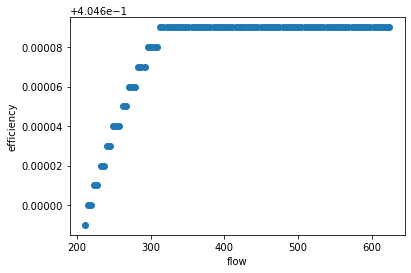

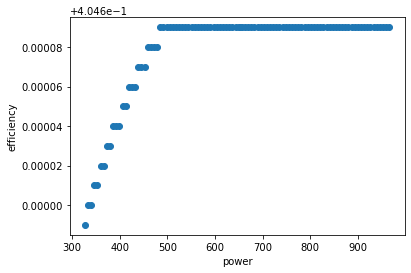

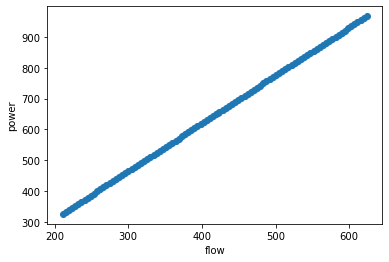

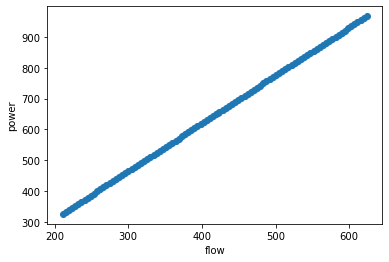

In [12]:
#plots

plt.figure()
plt.scatter(round(plant_sens_df['FSTEAM'],5),plant_sens_df['POUTNET']*-1)
plt.xlabel('flow')
plt.ylabel('power')

plt.figure()
plt.scatter(round(plant_sens_df['FSTEAM'],5),plant_sens_df['POUTNET']*-1)
plt.xlabel('flow')
plt.ylabel('power')

## Trombay Sensitivity: Max Temperatures

In [13]:
max_temp_list = [565, 665, 765, 865, 965]

output_maxtemps_df = pd.DataFrame()


for max_temp in max_temp_list:

    output_TES_temp_df = MS_TES_simulation(trombay,output_coal_trombay_df,peak_salt_temp=max_temp)
    
    output_maxtemps_df['temp'+str(max_temp)] = output_TES_temp_df[0].values


output_maxtemps_df.set_index(output_TES_temp_df.index).to_csv("output_df_maxtemps.csv")


0
540.15
1312289020.0
0
540.15
1312289020.0
0
540.15
1312289020.0
0
540.15
1312289020.0
0
540.15
1312289020.0


In [15]:
output_maxtemps_df=output_maxtemps_df.set_index(output_TES_temp_df.index)
output_maxtemps_df

,temp565,temp665,temp765,temp865,temp965
steam_eff,4.046137e-01,4.046137e-01,4.046137e-01,4.046137e-01,4.046137e-01
Qs,-3.477154e+06,-3.477154e+06,-3.477154e+06,-3.477154e+06,-3.477154e+06
P_out_net,5.309701e+02,5.309701e+02,5.309701e+02,5.309701e+02,5.309701e+02
F_salt,3.854680e+03,2.814957e+03,2.209820e+03,1.811955e+03,1.528848e+03
deltaA,2.500069e+01,1.250007e+02,2.250007e+02,3.250007e+02,4.250007e+02
deltaB,1.393964e+02,2.112346e+02,2.836991e+02,3.570836e+02,4.318593e+02
deltaC,7.304895e+01,1.207707e+02,1.691163e+02,2.183349e+02,2.688395e+02
deltaD,2.550217e+02,2.550168e+02,2.550240e+02,2.550002e+02,2.550014e+02
Q1,3.794606e+08,3.794606e+08,3.794606e+08,3.794606e+08,3.794606e+08
Q2,3.167016e+08,3.167016e+08,3.167016e+08,3.167016e+08,3.167016e+08


In [18]:
#checking the ratios stay constant

Q_tot = output_maxtemps_df.loc['Q1']+output_maxtemps_df.loc['Q2']+output_maxtemps_df.loc['Q3']
print(output_maxtemps_df.loc['Q1']/Q_tot)
print(output_maxtemps_df.loc['Q2']/Q_tot)
print(output_maxtemps_df.loc['Q3']/Q_tot)

temp565    0.289159
temp665    0.289159
temp765    0.289159
temp865    0.289159
temp965    0.289159
dtype: float64
temp565    0.241335
temp665    0.241335
temp765    0.241335
temp865    0.241335
temp965    0.241335
dtype: float64
temp565    0.469505
temp665    0.469505
temp765    0.469505
temp865    0.469505
temp965    0.469505
dtype: float64


## Uttar Pradesh fleet

In [21]:
#500 MW

inputdata_df = pd.read_excel("TES_Assumptions_2023.xlsx",sheet_name="AspenInputs_500MW",header=1).set_index('Variable Name').dropna(axis=1).drop('Notes_Sources')

#initialize output df
output_df = pd.DataFrame(data=np.zeros((len(output_var),len(inputdata_df.columns))), columns=inputdata_df.columns).set_index(output_var)

#run all the coal simulations
output_df,plant_sens_df = coal_simulation(inputdata_df,output_df)

#run all the MS TES simulations
output_TES_500_df = MS_TES_simulation(inputdata_df,output_df,peak_salt_temp=565)



500MW_0
537.15
1345561890.0
500MW_1
538.15
1329295820.0
500MW_2
537.15
1329252050.0
500MW_3
538.15
1332546670.0
500MW_4
538.15
1332536440.0


In [23]:
## read in data table
inputdata_df = pd.read_excel("TES_Assumptions_2023.xlsx",sheet_name="AspenInputs_2",header=1).set_index('Variable Name').dropna(axis=1).drop('Notes_Sources')

#remove the 500s
inputdata_df.drop(['500MW_0' ,'500MW_1' ,'500MW_2' ,'500MW_3','500MW_4'],axis=1,inplace=True) #columns 10 to 15 [10:15]

#initialize output df
output_initial_df = pd.DataFrame(data=np.zeros((len(output_var),len(inputdata_df.columns))), columns=inputdata_df.columns).set_index(output_var)

#run all the coal simulations
output_coal_df,plant_sens_df = coal_simulation(inputdata_df,output_initial_df)

#run all the MS TES simulations
output_TES_df = MS_TES_simulation(inputdata_df,output_coal_df,peak_salt_temp=565)


700MW
560.15


AttributeError: 'NoneType' object has no attribute 'Value'

In [ ]:
#add
output_TES_df_final = pd.concat([output_TES_df,output_TES_500_df], axis=1)


In [ ]:
output_TES_df

In [ ]:
# save file
output_TES_df_final.to_csv('output_df_UP.csv')

## scratch

In [ ]:
#### set salt flow rates to iterate over
#F = np.linspace(4000, 5000, 3)
F = [4200]

#set temperatures to iterate over
#max_temp_list = [565, 665, 765, 865, 965]
max_temp_list = [565]

#initialize lists
#eff_list = []
power_list = []
steamflow_list = []
lmtd_list = []
steam_peak_temp_list = []
max_temps = []
deltaA_list = []
deltaB_list = []
eff_list = []
UA_list = []

for F_salt in F:
    #reset F_salt
    aspen.Tree.FindNode("\Data\Streams\SALT1\Input\TOTFLOW\MIXED").Value = F_salt
    
    #initialize sublists
    eff_sublist =[]
    power_sublist= []
    steamflow_sublist =[]
    lmtd_salt_sublist = []
    steam_peak_temp_sublist=[]
    max_temps_sublist =[]
    
    deltaA_sublist = []
    deltaB_sublist = []
    
    UA_sublist = []
        
    aspen.Tree.FindNode("\Data\Streams\STEAM1\Input\TOTFLOW\MIXED").Value = 385
    
    for max_temp in max_temp_list:
        #set max_temp
        aspen.Tree.FindNode("\Data\Streams\SALT1\Input\TEMP\MIXED").Value = max_temp
        
        #run aspen model
        aspen.Engine.Run2()

        F_salt=aspen.Tree.FindNode("\Data\Streams\SALT1\Input\TOTFLOW\MIXED").Value

        #results
        h_1=aspen.Tree.FindNode("\Data\Streams\SALT1\Output\HMX_MASS\MIXED").Value
        h_2 =aspen.Tree.FindNode("\Data\Streams\SALT2\Output\HMX_MASS\MIXED").Value
        w_1 = aspen.Tree.FindNode("\Data\Streams\W1\Output\POWER_OUT").Value
        w_2 = aspen.Tree.FindNode("\Data\Streams\W2\Output\POWER_OUT").Value
        w_3 = aspen.Tree.FindNode("\Data\Streams\W3\Output\POWER_OUT").Value
        
        print(w_1,w_2,w_3)
        
        #enthalpy change of steam
        h_steam_1 = aspen.Tree.FindNode("\Data\Streams\STEAM1\Output\HMX_MASS\MIXED").Value
        h_steam_2 = aspen.Tree.FindNode("\Data\Streams\STEAM4\Output\HMX_MASS\MIXED").Value
        Qs = h_steam_1 - h_steam_2

        #work from pump
        w_pump = aspen.Tree.FindNode("\Data\Blocks\PUMP\Output\WNET").Value

        #lmtd from heat exchanger
        lmtd_salt = aspen.Tree.FindNode("\Data\Blocks\MHX\Output\LMTD").Value
        steam_peak_temp = aspen.Tree.FindNode("\Data\Streams\STEAM4\Output\TEMP_OUT\MIXED").Value -273
        
        deltaA = max_temp - steam_peak_temp
        deltaB = 290 - 50
        
        UA = aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\UA").Value* 10**-6 #change to divide by 1e6 to make MW

        #steam flow 
        steamflow = aspen.Tree.FindNode("\Data\Streams\STEAM1\Output\MASSFLMX\MIXED").Value

        #calculate metric (efficiency)
        eff = (w_1+w_2+w_3+w_pump) / (F_salt*(h_2-h_1))
        power = (w_1+w_2+w_3+w_pump) * -10**-6
        print(w_pump)
        eff_sublist.append(eff)
        power_sublist.append(power)
        steamflow_sublist.append(steamflow)
        lmtd_salt_sublist.append(lmtd_salt)
        steam_peak_temp_sublist.append(steam_peak_temp)
        max_temps_sublist.append(max_temp)
        deltaA_sublist.append(deltaA)
        deltaB_sublist.append(deltaB)
        UA_sublist.append(UA)


    #append to lists
    eff_list.append(eff_sublist)
    power_list.append(power_sublist)
    steamflow_list.append(steamflow_sublist)
    lmtd_list.append(lmtd_salt_sublist)
    steam_peak_temp_list.append(steam_peak_temp_sublist)
    max_temps.append(max_temps_sublist)
    deltaA_list.append(deltaA_sublist)
    deltaB_list.append(deltaB_sublist)
    UA_list.append(UA_sublist)
    
    
    


In [ ]:
max_temp

In [ ]:
print(deltaA_list)
print(deltaB_list)
print(eff_list)

In [ ]:
#double check lmtd
print(lmtd_list)
print((deltaB-deltaA) / (np.log(deltaB/deltaA)))

In [ ]:
h_steam_1

In [ ]:
# h_steam_2


In [ ]:
h_2

In [ ]:
#set cost of heat exchanger
c_base = 413918
UA_base = 9.82

cost_hx = c_base*(np.array(UA_list )/ UA_base)**0.6 # $1k
cost_hx

In [ ]:
#plots
#plot figures
# plt.figure()
# plt.scatter(np.repeat(F,5),eff_list)
# plt.xlabel('salt flow rate kg/s')
# plt.ylabel('efficiency');
# plt.title('efficiency vs salt flow rate')

# plt.figure()
# plt.scatter(np.repeat(F,5),power_list)
# plt.xlabel('salt flow rate(kg/s)')
# plt.ylabel('power MW');
# plt.title('power vs salt flow rate')

plt.figure()
plt.scatter(power_list,eff_list)
plt.xlabel('power MW')
plt.ylabel('efficiency');
plt.title('power vs. efficiency');

plt.figure()
plt.scatter(power_list,steamflow_list)
plt.xlabel('power MW')
plt.ylabel('steam flow (kg/s)');
plt.title('power vs. steam flow');

plt.figure()
plt.scatter(lmtd_list,eff_list)
plt.xlabel('LMTD heat exchanger')
plt.ylabel('efficiency');
plt.title('LMTD vs. efficiency');

fig,ax  = plt.subplots()
ax.scatter(max_temps,eff_list,color = 'red')
ax.set_ylabel('efficiency',color='red');
ax2=ax.twinx()
ax2.scatter(max_temps,UA_list,color='blue')
ax2.set_ylabel('UA [MW/K]',color='blue')
# ax2.scatter(max_temps,cost_hx,color='blue')
# ax2.set_ylabel('$1k',color='blue')

ax.set_xlabel('salt peak temperature (deg C)')
ax.set_title('efficiency and cost tradeoff w/ higher salt temp');

plt.show()

In [ ]:
eff_list

Notes:
* does not include aux power consumption, but includes aux power from pump
* the efficiency values are not so different (ranging from 0.35710 to 0.35730) 
* range of efficiency decreases with increase in peak salt temperature
* plots for different salt flow rates and different salt peak tempeatures
* to the design efficiency 

# Change the end-use

Use a different working directory

Vary the percent of steam flow serving a fixed industrial demand 

Vary the industrial demand (?) 

Vary the temperature of industrial steam

Plot how total efficiency varies with % of steam flow serving fixed industrial demand

Calculate the total efficiency: 

Equation: 
$$\eta = \frac{W_{out}+Q_{out}}{Q_{in}} = \frac{W_{out}+(F_{ind steam}*\Delta H_{ind steam})}{(F_{salt}*\Delta H_{salt})}$$






In [ ]:
#this is how you open an aspen file
path = 'C:\\Users\\MITEI_Athlete\\Desktop\\Serena_AspenModels\\Trombay_analysis\\Unit 5\\MS_TES_industrial\\Molten_industrial.apw'
aspen = win32.gencache.EnsureDispatch('Apwn.Document')
aspen.InitFromArchive2(path)

In [ ]:
#random generator
rng=np.random.default_rng(30)

#vary the percent of steam flow serving industrial demand
#percents = np.linspace(0.1, 0.8, 10) 
percents = rng.random(20)

#vary the salt flow rate (power)
#F = np.linspace(1000, 5000, 10)
F = rng.integers(low=1700, high=5000, size=20)



#initialize lists
eff_list = []
power_list = []
steamflow_list = []
lmtd_list = []
steam_peak_temp_list = []


#initialize lists
eff_list = [] #efficiency of overall system
power_list = [] #power output of coal plant (electric)
steamflow_list = [] 
steam_ind_temp_list=[]
Qs_list = []
lmtd_list = []
q_ind_list = []
slope_m_list = []
intercept_b_list = []
eff_power_list = []
lmtd_salt_list = []
F_salt_list = [] 

plt.figure(figsize=(12,9))

for F_salt in F:
    #reset F_salt
    aspen.Tree.FindNode("\Data\Streams\SALT1\Input\TOTFLOW\MIXED").Value = F_salt
    
    
    
    for p in percents:
    
        ### SET PERCENTAGE ###
        #set the percent split toward the industrial use case (decimal 0 to 1)
        aspen.Tree.FindNode("\Data\Blocks\SPLIT\Input\FRAC\STEAMLP").Value = p

        #pressure (bar)
        #aspen.Tree.FindNode("\Data\Streams\INDLOAD1\Input\PRES\MIXED").Value 


        ### RUN MODEL ###
        #run aspen model
        aspen.Engine.Run2()

        #kg/s industrial steam flow
        #steam_ind_flow = aspen.Tree.FindNode("\Data\Streams\INDIN\Output\TOTFLOW\MIXED").Value

        #F_salt
        #F_salt=aspen.Tree.FindNode("\Data\Streams\SALT1\Input\TOTFLOW\MIXED").Value 
        
        #if you want to vary the industrial steam temperature supplied:
        #aspen.Tree.FindNode("\Data\Flowsheeting Options\Design-Spec\INDSPEC\Input\EXPR2")

        ### RESULTS ###
        #enthalpy change of steam 
        h_steam_1 = aspen.Tree.FindNode("\Data\Streams\STEAM1\Output\HMX_MASS\MIXED").Value
        h_steam_2 = aspen.Tree.FindNode("\Data\Streams\STEAM4\Output\HMX_MASS\MIXED").Value
        Qs = h_steam_1 - h_steam_2

        #enthalpy change of salt
        h_1=aspen.Tree.FindNode("\Data\Streams\SALT1\Output\HMX_MASS\MIXED").Value
        h_2 =aspen.Tree.FindNode("\Data\Streams\SALT2\Output\HMX_MASS\MIXED").Value

        #work out from turbines (power)
        w_1 = aspen.Tree.FindNode("\Data\Streams\W1\Output\POWER_OUT").Value
        w_2 = aspen.Tree.FindNode("\Data\Streams\W2\Output\POWER_OUT").Value
        w_LP1 = aspen.Tree.FindNode("\Data\Streams\WLP1\Output\POWER_OUT").Value
        w_LP2 = aspen.Tree.FindNode("\Data\Streams\WLP2\Output\POWER_OUT").Value

        #work from pump and condensors
        w_pump = aspen.Tree.FindNode("\Data\Blocks\PUMP\Output\WNET").Value
        q_cond = aspen.Tree.FindNode("\Data\Blocks\CONDENSE\Output\QNET").Value #but this is negative

        #heat to industrial process
        #ind_h1 = aspen.Tree.FindNode("\Data\Streams\INDIN\Output\HMX_MASS\MIXED").Value
        #ind_h2 = aspen.Tree.FindNode("\Data\Streams\INDOUT\Output\HMX_MASS\MIXED").Value

        q_ind =  aspen.Tree.FindNode("\Data\Streams\QIND\Output\QCALC").Value*-1
        
        #LMTD in salt-steam heat exchanger
        lmtd_salt = aspen.Tree.FindNode("\Data\Blocks\MHX\Output\LMTD").Value

        #print(w_LP1)

        #steam flow 
        steamflow = aspen.Tree.FindNode("\Data\Streams\STEAM1\Output\MASSFLMX\MIXED").Value
        #print(steamflow)

        #calculate metric (efficiency)
        eff = (w_1+w_2+w_LP1+w_LP2+w_pump+q_ind) / (F_salt*(h_2-h_1))
        power = (w_1+w_2+w_LP1+w_LP2+w_pump) * -10**-6 #net power
        eff_power = (w_1+w_2+w_LP1+w_LP2+w_pump) / (F_salt*(h_2-h_1))
        #industrial steam final temperature
        #steam_ind_temp = aspen.Tree.FindNode("\Data\Streams\INDIN\Output\TEMP_OUT\MIXED").Value-273

        #append to lists
        eff_list.append(eff)
        power_list.append(power)
        #steam_ind_temp_list.append(steam_ind_temp)
        #Qs_list.append(Qs)
        q_ind_list.append(q_ind*-10**-6)
        eff_power_list.append(eff_power)
        lmtd_salt_list.append(lmtd_salt)
        F_salt_list.append(F_salt/1000) #convert kg/s to tonne/s
    
    #define slope
    slope_m,intercept_b = np.polyfit(q_ind_list,eff_power_list,deg=1)
    slope_m_list.append(slope_m)
    intercept_b_list.append(intercept_b)
    
        
    ### PLOT ###
#     plt.plot(q_ind_list,eff_power_list,label=str(round(max(power_list)))+" MW")
#     plt.xlabel('industrial heat demand (MW_th)')
#     plt.ylabel('power cycle efficiency');
#     plt.title('power cycle efficiency vs industrial demand');
    
    
#     plt.plot(power_list,eff_power_list,label=str(round(F_salt))+" kg/s")
#     plt.xlabel('electrical power (MW)')
#     plt.ylabel('efficiency of power cycle');
#     plt.title('power vs power efficiency')
    
    
#     plt.plot(percents,lmtd_salt_list,label=str(round(F_salt))+" kg/s")
#     plt.xlabel('percentage')
#     plt.ylabel('LMTD salt');
#     plt.title('percentage vs LMTD')
    
#     plt.plot(percents,power_list,label=str(round(F_salt))+" kg/s")
#     plt.xlabel('percentage')
#     plt.ylabel('power output (MW)');
#     plt.title('percentage vs power output (MW)')
    
    
#plt.legend()


#plot slope and intercepts as function of salt fow
    
# plt.figure()
# plt.plot(F,slope_m_list)
# plt.xlabel('Salt Flow')
# plt.ylabel('slope');
# plt.title('power cycle efficiency slope vs salt flow')
    
    
# plt.figure()
# plt.plot(F,intercept_b_list)
# plt.xlabel('Salt Flow')
# plt.ylabel('intercept');
# plt.title('intercept vs salt flow')
    
#plot figures
# plt.figure()
# plt.plot(q_ind_list,eff_list)
# plt.xlabel('industrial heat demand')
# plt.ylabel('efficiency');
# plt.title('efficiency vs industrial demand')

# plt.figure()
# plt.plot(percents,power_list)
# plt.xlabel('percent to industrial load');
# plt.ylabel('power MW')
# plt.title('power vs. percent');


# plt.figure()
# plt.plot(percents,Qs_list)
# plt.xlabel('percent to industrial load')
# plt.ylabel('Q_steam (J/kg)');
# plt.title('percent vs. Qs');

# plt.figure()
# plt.plot(eff_list,power_list)
# plt.xlabel('efficinecy')
# plt.ylabel('power');
# plt.title('efficiency vs electric power');



In [ ]:
#set X an array for F_salt and Q_steam
X = np.array([[power_list[i],q_ind_list[i]] for i in np.arange(len(q_ind_list))])

#set y to power output values
y = np.array(F_salt_list*np.ones(400)*1000)

#regression
reg = LinearRegression().fit(X, y)

#regression results
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)

In [ ]:
rng=np.random.default_rng(3)
power_test = rng.integers(low=200, high=700, size=100)
q_ind_test = rng.integers(low=50, high=1000, size=100)


X_test = np.array([[power_test[i],q_ind_test[i]] for i in np.arange(len(q_ind_test))])
y_pred = reg.predict(X_test)


In [ ]:

plt.figure()
plt.scatter(q_ind_list, y,label = 'actual')
plt.scatter(q_ind_test,y_pred,label='test')
plt.ylabel('Salt Flow (kg/s)')
plt.xlabel('Industrial demand (MW_th)');
plt.legend()

plt.figure()
plt.scatter(power_list,y,label='actual')
plt.scatter(power_test,y_pred,label='test')
plt.ylabel('Salt Flow (kg/s)')
plt.xlabel('Power Ouput (MW_e)');
plt.legend();

In [ ]:
plt.figure()
plt.scatter(power_list,q_ind_list,label='actual')
plt.scatter(power_test,q_ind_test,label='test')
plt.ylabel('Industrial Load (MW_th)')
plt.xlabel('Power Ouput (MW_e)');
plt.legend();

In [ ]:

plt.figure()
plt.plot(F,slope_m_list,label='actual')
p3 = np.poly1d(np.polyfit(F,slope_m_list, 3))

residual = np.polyfit(F,slope_m_list, 3,full=True)[1]
print('residual: ', residual)

xp=np.linspace(1000,5000,30)

plt.plot(xp,p3(xp),label='predicted')
plt.xlabel('Salt Flow')
plt.ylabel('slope');
plt.title('total efficiency slope vs salt flow')

plt.legend();

    
# plt.figure()
# plt.plot(F,intercept_b_list)
# plt.xlabel('Salt Flow')
# plt.ylabel('intercept');
# plt.title('intercept vs salt flow')

In [ ]:
print('maximum efficiency: ',round(eff,2))

In [ ]:
384*3406*0.35/1000 

# vary other parameters

* how does Qs change (heat exchanger to turbine, pump to heat exchanger)

$$ Qs = h_{steam}(540\deg C) - h_{steam}(50 \deg C) $$

In [ ]:
#this is how you open an aspen file
path = 'C:\\Users\\MITEI_Athlete\\Desktop\\Serena_AspenModels\\Trombay_analysis\\Unit 5\\MS_TES_industrial\\Molten_v4.apw'
aspen = win32.gencache.EnsureDispatch('Apwn.Document')
aspen.InitFromArchive2(path)

In [ ]:
#vary the percent of steam flow serving industrial demand
#percents = np.linspace(0.1, 1, 10) 

#vary industrial steam flow or pressure
steam_ind_flow_list = np.linspace(10, 500, 10) #kg/s

#initialize lists
eff_list = [] #efficiency of overall system
power_list = [] #power output of coal plant
steamflow_list = [] 
steam_ind_temp_list=[]

for steam_ind_flow in steam_ind_flow_list:
    
    #set the percent split toward the industrial use case (decimal 0 to 1)
    aspen.Tree.FindNode("\Data\Blocks\SPLIT\Input\FRAC\INDHOT1").Value = 0.5
    
    #set industrial steam flow (kg/s)
    aspen.Tree.FindNode("\Data\Streams\INDLOAD1\Input\TOTFLOW\MIXED").Value = steam_ind_flow
    
    #get steam flow to LP turbine (kg/s)
    steam_LP_flow = aspen.Tree.Data.Streams.STEAMLP.Output.MASSFLOW3.WATER.Value
    #get temperature of steam into LP turbine (degC)
    steam_LP_temp = aspen.Tree.FindNode("\Data\Streams\STEAMLP\Output\TEMP_OUT\MIXED").Value -273
   
    
    #pressure (bar)
    #aspen.Tree.FindNode("\Data\Streams\INDLOAD1\Input\PRES\MIXED").Value 
    
    #run aspen model
    aspen.Engine.Run2()
    
    ### RESULTS ###
    #enthalpy change of steam 
    h_steam_1 = aspen.Tree.FindNode("\Data\Streams\STEAM1\Output\HMX_MASS\MIXED").Value
    h_steam_2 = aspen.Tree.FindNode("\Data\Streams\STEAM4\Output\HMX_MASS\MIXED").Value
    
    #enthalpy change of salt
    h_1=aspen.Tree.FindNode("\Data\Streams\SALT1\Output\HMX_MASS\MIXED").Value
    h_2 =aspen.Tree.FindNode("\Data\Streams\SALT2\Output\HMX_MASS\MIXED").Value
    
    #work out from turbines (power)
    w_1 = aspen.Tree.FindNode("\Data\Streams\W1\Output\POWER_OUT").Value
    w_2 = aspen.Tree.FindNode("\Data\Streams\W2\Output\POWER_OUT").Value
    w_3 = aspen.Tree.FindNode("\Data\Streams\W3\Output\POWER_OUT").Value
    
    #work from pump and condensors
    w_pump = aspen.Tree.FindNode("\Data\Blocks\PUMP\Output\WNET").Value
    q_cond = aspen.Tree.FindNode("\Data\Blocks\CONDENSE\Output\QNET").Value #but this is negative
    
    #heat to industrial process
    #q_ind = aspen.Tree.FindNode("\Data\Blocks\HX\Output\QCALC2").Value
    ind_h1 = aspen.Tree.FindNode("\Data\Streams\INDLOAD1\Output\HMX_MASS\MIXED").Value
    ind_h2 = aspen.Tree.FindNode("\Data\Streams\INDLOAD2\Output\HMX_MASS\MIXED").Value
    
    q_ind = steam_ind_flow * (ind_h1 - ind_h2)
    #print(q_ind)
    
    #steam flow 
    steamflow = aspen.Tree.FindNode("\Data\Streams\STEAM1\Output\MASSFLMX\MIXED").Value
    #print(steamflow)
    
    #calculate metric (efficiency)
    eff = (w_1+w_2+w_3+w_pump+q_ind) / (F_salt*(h_2-h_1))
    power = (w_1+w_2+w_3+w_pump) * -10**-6
    
    #other helpful metrics potentially
    lmtd_hx_ind = aspen.Tree.FindNode("\Data\Blocks\HX\Output\LMTD").Value
    
    #industrial steam final temperature
    steam_ind_temp = aspen.Tree.FindNode("\Data\Streams\INDLOAD2\Output\TEMP_OUT\MIXED").Value-273
    
    #append to lists
    eff_list.append(eff)
    power_list.append(power)
    #steamflow_list.append(steamflow)
    steam_ind_temp_list.append(steam_ind_temp)
    
    
    
#plot figures
plt.figure()
plt.plot(steam_ind_flow_list,eff_list)
plt.xlabel('industrial steam flow (kg/s)')
plt.ylabel('efficiency');
plt.title('efficiency vs industrial steam flow')

plt.figure()
plt.plot(steam_ind_flow_list,power_list)
plt.xlabel('industrial steam flow (kg/s)');
plt.ylabel('power MW')
plt.title('power vs. industrial steam flow ');

plt.figure()
plt.plot(steam_ind_flow_list,steam_ind_temp_list)
plt.xlabel('industrial steam flow (kg/s)')
plt.ylabel('industrial steam temperature(degC)');
plt.title('industrial steam flow vs. industrial steam temp');

# Bottom Up Study

The purpose of the following section is to adjust:
* steam flow rate 
* main steam temperature and pressure
* aux consumption
* power output 

in order to find the appropriate input parameters for different units, going beyond the 500 MW initial case study

the inputs are documented in the TES_assumptions_2023.xlsx file

the outputs from the aspen models that check that everything is working as intended
* coal plant efficiency is the same as given efficiency
* examine impacts of part load efficiency
* retrofit efficiency is similar to coal plant efficiency

the outputs from the aspen models that are inputs to the TES optimization: 
- **deltaT_A**
- **deltaT_B**
- ***Qs - steam enthalpy change***
- flowSteam_peak
- steam_eff
- industrial use case sensitivity: beta_1, beta_2, beta_3 (holding off on this, for industrial / captive use) 
- peak temperature sensitivity: efficiency tradeoff with cost of heat exchanger



### Coal Plant Simulation efficiencies and input efficiencies

Changed them all to 0.9, with design spec activtated that sets LP output pressure to set the efficeincy

texbook gives 0.08 to 0.15 for pressure outlet LP

### Coal Plant Calibration

In [299]:
def coal_simulation(inputdata_df, output_df):
    #set the path
    path = 'C:\\Users\\MITEI_Athlete\\Desktop\\Serena_AspenModels\\Trombay_analysis\\Unit 5\\coal_plant\\rankine_supercritical_MS.apw'
    aspen = win32.gencache.EnsureDispatch('Apwn.Document')
    aspen.InitFromArchive2(path)

    #set columns to iterate over
    plant_list = inputdata_df.columns

    #for every plant type in the data inputs
    for plantID in plant_list:

        #get the target steam efficiency from the inputs
        target_steam_eff = inputdata_df.loc['steam_eff',plantID] 

       #SET VALUES
        #set the max and min steam flowrate for the design spec in aspen 
        #aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\DS-1\Input\LOWER").Value = inputdata_df.loc['F_steam',plantID]/2
        #aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\DS-1\Input\UPPER").Value = inputdata_df.loc['F_steam',plantID]*1.5

        #set the max and min LP output pressure
        aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\DS-1\Input\LOWER").Value = 0.0475 #0.0475 #corresponds to 35 C
        aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\DS-1\Input\UPPER").Value = 0.15

        #set the effciiency output
        aspen.Tree.FindNode("\Data\Flowsheeting Options\Design-Spec\DS-1\Input\EXPR2").Value = target_steam_eff
        #set the power tolerance to something (10 MW)
        aspen.Tree.FindNode("\Data\Flowsheeting Options\Design-Spec\DS-1\Input\TOL").Value = 0.001

        #seperate flow closed loop
        #set steam flow fixed
        aspen.Tree.FindNode("\Data\Streams\IN\Input\TOTFLOW\MIXED").Value = inputdata_df.loc['F_steam',plantID] 

        #main steam pressure
        aspen.Tree.FindNode("\Data\Streams\IN\Input\PRES\MIXED").Value = inputdata_df.loc['Pressure_steam',plantID]


        #set steam flow fixed
        aspen.Tree.FindNode("\Data\Streams\STREAM24\Input\TOTFLOW\MIXED").Value = inputdata_df.loc['F_steam',plantID] 

        #main steam temperature C
        aspen.Tree.FindNode("\Data\Blocks\BOILER\Input\TEMP").Value = inputdata_df.loc['Temperature_steam',plantID]

        #main steam pressure
        aspen.Tree.FindNode("\Data\Blocks\PUMP\Input\PRES").Value = inputdata_df.loc['Pressure_steam',plantID] 

        #IP steam temperature
        aspen.Tree.FindNode("\Data\Blocks\BOILER2\Input\TEMP").Value = inputdata_df.loc['Temperature_steam',plantID]

        #aux consumption 
        aspen.Tree.FindNode("\Data\Streams\AUX\Input\POWER").Value = inputdata_df.loc['P_aux_coal',plantID] #in MW

        #change the steam flow in the senstiivty range
        aspen.Tree.FindNode("\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Input\\LOWER\\#1").Value = inputdata_df.loc['F_steam',plantID] / 2
        aspen.Tree.FindNode("\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Input\\UPPER\\#1").Value = inputdata_df.loc['F_steam',plantID] * 1.5

        #RUN ASPEN MODEL
        aspen.Engine.Run2()

        #target_pres = 0
        lp_file = "\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Output\\SENSVAR2\\1\\"
        plant_sens_df = pd.DataFrame()
        #for each row in the table
        for row in np.arange(1,100):
            plant_sens_row = pd.DataFrame()
            #low pressure turbine output (sensitivity variable)
            flow = aspen.Tree.FindNode(lp_file+str(row)).Value
            #set in the df
            plant_sens_row['flow'] = [flow]
            #get the column value
            for col in np.arange(1,16):

                #name of the column (HEATIn etc)
                col_name = aspen.Tree.FindNode("\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Output\\VARID\\"+str(col)).Value
                value = aspen.Tree.FindNode("\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Output\\SENSVAR2\\"+str(col+1)+"\\"+str(row)).Value

                #set in the df 
                plant_sens_row[col_name]=[value]


            #append to df 
            plant_sens_df=plant_sens_df.append(plant_sens_row)

        #analyze the plant_sens_df efficiency
        #eff_round = round((plant_sens_df['W1']+plant_sens_df['W2']+plant_sens_df['W3'])/plant_sens_df['HEATIN'],4)
        plant_sens_df['eff'] = (plant_sens_df['W1']+plant_sens_df['W2']+plant_sens_df['W3'])/plant_sens_df['HEATIN']


        #reset plant_sens_df temps are larger than 35
        # plant_sens_df =  plant_sens_df[plant_sens_df['LPTEMPO'] >= 35]

        target_power = (inputdata_df.loc['P_out',plantID] + inputdata_df.loc['P_aux_coal',plantID]  )*-1

        #find column where plant power is same as target
       # targets_df = plant_sens_df[plant_sens_df['eff'] == target_steam_eff]

        #if there's nothing in the targets_df, just get the row w/ the closest power and greater than 35 C outlet temp
        #if len(targets_df) == 0:

            #plants_sens_df =  plant_sens_df[plant_sens_df['LPTEMPO'] >= 35]
            #targets_df =   pd.DataFrame(plant_sens_df.iloc[np.argmin(abs(plant_sens_df['POUTNET']-target_power))]).T 

        targets_df =   pd.DataFrame(plant_sens_df.iloc[np.argmin(abs(plant_sens_df['POUTNET']-target_power))]).T 

        #save the plant_sens_df to comb through
        plant_sens_df.to_excel(str(plantID)+'sensitivity'+'.xlsx')

        #take the last target row to the calibrated plant outputs, has highest steam flow rate
        plant_calibrated = targets_df[-1:]

        #take the first row to the calibrated plant run 
        #plant_calibrated = targets_df[:1] 

        ## STORE RESULTS IN OUTPUT DF
        #eff_net = plant_calibrated['POUTNET']/plant_calibrated['HEATIN']

        output_df.loc['coal_steam_eff',plantID]=plant_calibrated['eff'][0]
        output_df.loc['target_pressure',plantID]=plant_calibrated['LPPRESO'][0]

        #HP output
        output_df.loc['HP_output_T_coal',plantID]= plant_calibrated['HPTEMP'][0]
        output_df.loc['HP_output_P_coal',plantID] = plant_calibrated['HPPRES'][0] 

        #IP input
        output_df.loc['IP_input_T_coal',plantID]= plant_calibrated['IPTEMP'][0]
        output_df.loc['IP_input_P_coal',plantID] = plant_calibrated['IPPRES'][0]

        #LP input (IP output)
        output_df.loc['LP_input_T_coal',plantID]= plant_calibrated['LPTEMPIN'][0]
        output_df.loc['LP_input_P_coal',plantID] = plant_calibrated['LPPRESIN'][0]

        #LP output
        output_df.loc['LP_output_T_coal',plantID]= plant_calibrated['LPTEMPO'][0]

        #print the plantID if the LP tempout is less than 35
        if plant_calibrated['LPTEMPO'][0] < 35: 
            print('LP tempout: ', plantID, plant_calibrated['LPTEMPO'][0])

        output_df.loc['LP_output_P_coal',plantID] = plant_calibrated['LPPRESO'][0]

        #vapor fraction out of LP turbine
        output_df.loc['LP_vaporfraction_coal',plantID] = plant_calibrated['LPVF'][0]

        #print the plantID if the LPVF less than 0.8
        if plant_calibrated['LPVF'][0] < 0.80: 
            print('LP VF: ', plantID, plant_calibrated['LPVF'][0])

        #net power output
        output_df.loc['coal_power_net',plantID] = plant_calibrated['POUTNET'][0] #this is the work from the turbines, no aux, no pump

        #steam flow calibrated
        output_df.loc['flowsteam_calibrated',plantID] = plant_calibrated['FSTEAM'][0]
        
    return output_df

## molten salt TES simulations
- set the LP outlet target pressure and steam flow rate according to the coal plant simulation 

In [298]:
## read in data table
inputdata_df = pd.read_excel("TES_Assumptions_2023.xlsx",sheet_name="AspenInputs_2",header=1).set_index('Variable Name').dropna(axis=1).drop('Notes_Sources')

#initialize output df
output_initial_df = pd.DataFrame(data=np.zeros((len(output_var),len(inputdata_df.columns))), columns=inputdata_df.columns).set_index(output_var)

#run all the coal simulations
output_coal_df,plant_sens_df = coal_simulation(inputdata_df,output_initial_df)

#run all the MS TES simulations
output_TES_df = MS_TES_simulation(inputdata_df,output_coal_df)

KeyboardInterrupt: 

In [273]:
## read in the 500 MW units
inputdata_df = pd.read_excel("TES_Assumptions_2023.xlsx",sheet_name="AspenInputs_500MW",header=1).set_index('Variable Name').dropna(axis=1).drop('Notes_Sources')


#initialize output df
output_df = pd.DataFrame(data=np.zeros((len(output_var),len(inputdata_df.columns))), columns=inputdata_df.columns).set_index(output_var)

#run all the coal simulations
output_df,plant_sens_df = coal_simulation(inputdata_df,output_df)

#run all the MS TES simulations
output_TES_500_df = MS_TES_simulation(inputdata_df,output_df)

#replace
output_TES_df.iloc[:,10:15] = output_TES_500_df
output_TES_df
#save output
#output_TES_df.to_csv('output_df.csv')

,700MW,600MW,660MW,500MW,250MW,210MW,195_200MW,140MW,120_125MW,100_110MW,...,120_125MW_7,120_125MW_8,100_110MW_0,100_110MW_1,100_110MW_2,100_110MW_3,100_110MW_4,100_110MW_5,100_110MW_6,100_110MW_7
steam_eff,4.318568e-01,4.162364e-01,4.162364e-01,4.104755e-01,4.068047e-01,4.050303e-01,4.037477e-01,4.032862e-01,4.022596e-01,4.014904e-01,...,4.017821e-01,4.033061e-01,3.892024e-01,4.018787e-01,4.017821e-01,4.025827e-01,4.049051e-01,4.045724e-01,4.012926e-01,4.028265e-01
Qs,-3.568974e+06,-3.533564e+06,-3.533564e+06,-3.468702e+06,-3.476428e+06,-3.478886e+06,-3.482870e+06,-3.486180e+06,-3.483687e+06,-3.485099e+06,...,-3.478299e+06,-3.488709e+06,-3.493199e+06,-3.478149e+06,-3.478299e+06,-3.489819e+06,-3.486117e+06,-3.486673e+06,-3.479046e+06,-3.489449e+06
P_out_net,7.182713e+02,6.236029e+02,6.802940e+02,5.365357e+02,2.731827e+02,2.293506e+02,2.170711e+02,1.540523e+02,1.327185e+02,1.204848e+02,...,1.361642e+02,1.386649e+02,1.205086e+02,1.198196e+02,1.262406e+02,1.206465e+02,1.196248e+02,1.205262e+02,1.248782e+02,1.252635e+02
F_salt,4.970009e+03,4.456030e+03,4.860222e+03,3.889362e+03,1.995712e+03,1.681993e+03,1.596279e+03,1.134170e+03,9.795211e+02,8.910033e+02,...,1.006157e+03,1.020843e+03,9.164342e+02,8.852778e+02,9.329793e+02,8.897197e+02,8.778074e+02,8.851242e+02,9.238140e+02,9.231745e+02
deltaA,-2.815000e+01,-1.150000e+00,-1.150000e+00,2.725000e+01,2.725000e+01,2.755000e+01,2.685000e+01,2.585000e+01,2.745000e+01,2.735000e+01,...,2.985000e+01,2.485000e+01,2.985000e+01,2.985000e+01,2.985000e+01,2.485000e+01,2.485000e+01,2.485000e+01,2.985000e+01,2.485000e+01
deltaB,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,...,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02
flowsteamPeak,4.301515e+02,3.888889e+02,4.242424e+02,3.470839e+02,1.774168e+02,1.493287e+02,1.414718e+02,1.003893e+02,8.675926e+01,7.884736e+01,...,8.928171e+01,9.027778e+01,8.072391e+01,7.856341e+01,8.278058e+01,7.863636e+01,7.772727e+01,7.834596e+01,8.194444e+01,8.161476e+01
coal_steam_eff,4.318569e-01,4.162364e-01,4.162364e-01,4.104754e-01,4.068047e-01,4.050303e-01,4.037477e-01,4.032862e-01,4.022596e-01,4.014904e-01,...,4.017821e-01,4.033061e-01,3.892024e-01,4.018787e-01,4.017821e-01,4.025827e-01,4.049051e-01,4.045725e-01,4.012926e-01,4.028265e-01
target_pressure,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,...,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02
HP_input_T_MS,8.661500e+02,8.391500e+02,8.391500e+02,8.107500e+02,8.107500e+02,8.104500e+02,8.111500e+02,8.121500e+02,8.105500e+02,8.106500e+02,...,8.081500e+02,8.131500e+02,8.081500e+02,8.081500e+02,8.081500e+02,8.131500e+02,8.131500e+02,8.131500e+02,8.081500e+02,8.131500e+02


In [278]:
inputdata_df = pd.read_excel("TES_Assumptions_2023.xlsx",sheet_name="AspenInputs_2",header=1).set_index('Variable Name').dropna(axis=1).drop('Notes_Sources')


Text(0, 0.5, 'Temperature MS')

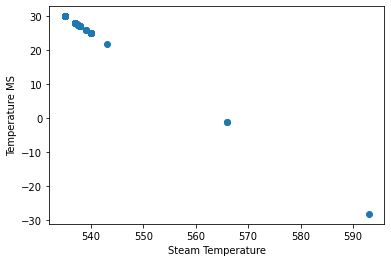

In [282]:
#plot the input temp vs output temp (does it reach the peak temps? )
plt.scatter(inputdata_df.loc['Temperature_steam',:],output_TES_df.loc['deltaA',:])
plt.xlabel('Steam Temperature')
plt.ylabel('Temperature MS')


Text(0, 0.5, 'Temperature MS')

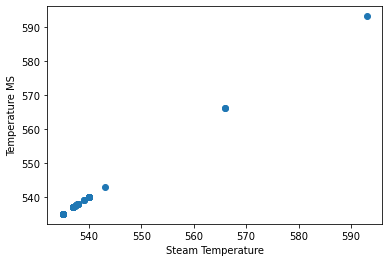

In [284]:
plt.scatter(inputdata_df.loc['Temperature_steam',:],output_TES_df.loc['HP_input_T_MS',:]-273)
plt.xlabel('Steam Temperature')
plt.ylabel('Temperature MS')

Text(0, 0.5, 'Temperature MS')

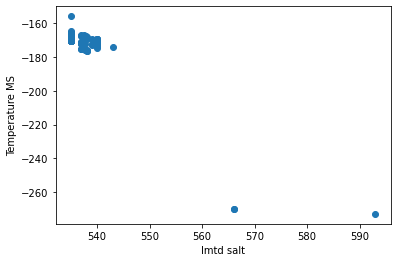

In [286]:
plt.scatter(inputdata_df.loc['Temperature_steam',:],output_TES_df.loc['lmtd_salt',:]-273)
plt.xlabel('lmtd salt')
plt.ylabel('Temperature MS')

In [ ]:
# check the coal plant steam effciiencies
plt.figure()
plt.scatter(inputdata_df.loc['steam_eff',:],output_df.loc['coal_steam_eff',:])
#plt.scatter(inputdata_df.iloc[1,:],output_df.loc['coal_steam_eff',:])
plt.xlabel('input CFPP design efficiency ')
plt.ylabel('aspen CFPP efficiency ')
plt.ylim(bottom=0.4,top = 0.5)
plt.xlim(left = 0.4,right=0.5)
plt.axline((0,0),slope=1)

#check if there is systematic bias
plt.figure()
plt.scatter(inputdata_df.loc['P_out',:],abs(inputdata_df.loc['P_out',:]+inputdata_df.loc['P_aux_coal',:]-output_df.loc['coal_power_net',:]*-1))
plt.xlabel('Unit Capacity')
plt.ylabel('difference in power')

plt.figure()
plt.scatter(inputdata_df.iloc[1,:],abs(inputdata_df.iloc[1,:]-output_df.loc['coal_steam_eff',:]))
plt.xlabel('input efficiency')
plt.ylabel('error')

Text(0, 0.5, 'coal plant simulation efficiency')

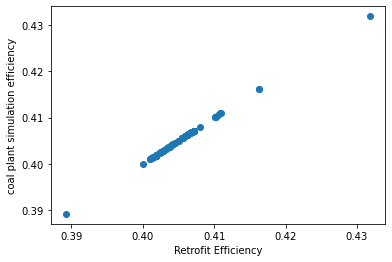

In [280]:
#which ones are the low eff ones? prob have MX issues
plt.scatter(output_TES_df.loc['steam_eff',:],output_TES_df.loc['coal_steam_eff',:])
plt.xlabel('Retrofit Efficiency')
plt.ylabel('coal plant simulation efficiency')




Text(0, 0.5, 'coal plant simulation efficiency')

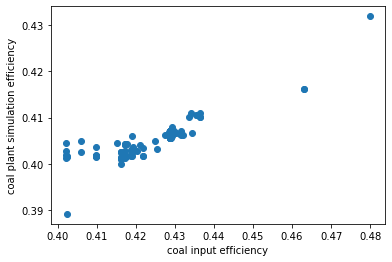

In [287]:
plt.scatter(inputdata_df.loc['steam_eff',:],output_TES_df.loc['coal_steam_eff',:])
plt.xlabel('coal input efficiency')
plt.ylabel('coal plant simulation efficiency')

In [ ]:
plt.scatter(output_TES_df.loc['F_salt',:],inputdata_df.loc['P_out',:])
plt.xlabel('Peak Salt Flow Rate')
plt.ylabel('Power (MW)')
plt.savefig('saltflows.jpeg')

## Checking for Part Load Efficiency

In [210]:

def MS_TES_simulation_partload(inputdata_df, output_df,part_load):
    #molten salt TES path
    path = 'C:\\Users\\MITEI_Athlete\\Desktop\\Serena_AspenModels\\Trombay_analysis\\Unit 5\\MS_TES_standalone\\Molten_v4.apw'
    aspen = win32.gencache.EnsureDispatch('Apwn.Document')
    aspen.InitFromArchive2(path)

    #set columns to iterate over
    plant_list = inputdata_df.columns


    #for every plant type in the data inputs
    for plantID in plant_list:

        #SET VALUES
        #steam flowrate
        aspen.Tree.FindNode("\Data\Streams\STEAM1\Input\TOTFLOW\MIXED").Value = output_df.loc['flowsteam_calibrated',plantID]*part_load

        #main steam temperature
        #set in heat exchanger
        aspen.Tree.FindNode("\Data\Blocks\MHX\Input\VALUE\STEAM1").Value = inputdata_df.loc['Temperature_steam',plantID]
        #set in steam 1
        aspen.Tree.FindNode("\Data\Streams\STEAM1\Input\TEMP\MIXED").Value = 35 

        #main steam pressure for steam1 and the pump discharge pressure
        aspen.Tree.FindNode("\Data\Streams\STEAM1\Input\PRES\MIXED").Value = inputdata_df.loc['Pressure_steam',plantID]
        aspen.Tree.FindNode("\Data\Blocks\PUMP\Input\PRES").Value = inputdata_df.loc['Pressure_steam',plantID]

        #IP steam temperature
        #set in heat exchanger output
        aspen.Tree.FindNode("\Data\Blocks\MHX\Input\VALUE\STEAM3").Value = inputdata_df.loc['Temperature_steam',plantID]

        #aux consumption 
        aspen.Tree.FindNode("\Data\Streams\AUX\Input\POWER").Value = inputdata_df.loc['P_aux_TES',plantID]

        #target output pressure from LP turbine, set by the coal plant simulation
        aspen.Tree.FindNode("\Data\Blocks\LP\Input\PRES").Value = output_df.loc['LP_output_P_coal',plantID] 

        #reset lower and upper bounds of design spec (originally 1000 to 5000 kg/s but hitting that constraint with different plants)
        aspen.Tree.FindNode("\Data\Flowsheeting Options\Design-Spec\FLOWRATE\Input\LOWER").Value = 10
        aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\FLOWRATE\Input\UPPER").Value = 7000

        #RUN ASPEN MODEL
        aspen.Engine.Run2()

        #CALCULATE RESULTS

        #results
        h_1=aspen.Tree.FindNode("\Data\Streams\SALT1\Output\HMX_MASS\MIXED").Value
        h_2 =aspen.Tree.FindNode("\Data\Streams\SALT2\Output\HMX_MASS\MIXED").Value

        w_1 = aspen.Tree.FindNode("\Data\Streams\W1\Output\POWER_OUT").Value
        w_2 = aspen.Tree.FindNode("\Data\Streams\W2\Output\POWER_OUT").Value
        w_3 = aspen.Tree.FindNode("\Data\Streams\W3\Output\POWER_OUT").Value

        F_salt = aspen.Tree.FindNode("\Data\Streams\SALT1\Output\MASSFLOW\MIXED\POTAS-01").Value + aspen.Tree.FindNode("\Data\Streams\SALT1\Output\MASSFLOW\MIXED\SODIU-01").Value #kg/s

        #enthalpy change of steam
        h_steam_1 = aspen.Tree.FindNode("\Data\Streams\STEAM1\Output\HMX_MASS\MIXED").Value
        h_steam_2 = aspen.Tree.FindNode("\Data\Streams\STEAM4\Output\HMX_MASS\MIXED").Value
        Qs = h_steam_1 - h_steam_2 

        #work from pump
        w_pump = aspen.Tree.FindNode("\Data\Blocks\PUMP\Output\WNET").Value

        #lmtd from heat exchanger
        lmtd_salt = aspen.Tree.FindNode("\Data\Blocks\MHX\Output\LMTD").Value
        steam_peak_temp = aspen.Tree.FindNode("\Data\Streams\STEAM4\Output\TEMP_OUT\MIXED").Value - 273
        max_temp = aspen.Tree.FindNode("\Data\Streams\SALT1\Input\TEMP\MIXED").Value

        deltaA = max_temp - steam_peak_temp
        deltaB = 290 - 50

        UA = aspen.Tree.FindNode(r"\Data\Blocks\MHX\Output\UA").Value # * 10**-6 #change to divide by 1e6 to make MW

        #steam flow 
        steamflow = aspen.Tree.FindNode("\Data\Streams\STEAM1\Output\MASSFLMX\MIXED").Value

        #calculate metric (efficiency)
        eff = (w_1+w_2+w_3) / (F_salt*(h_2-h_1))
        power = (w_1+w_2+w_3+w_pump+inputdata_df.loc['P_aux_TES',plantID]) * -10**-6

        #STORE RESULTS
        output_var = pd.Index(['steam_eff','Qs','P_out_net','F_salt','deltaA','deltaB','flowsteamPeak','lmtd_salt','UA'])
        output_df.loc['steam_eff',plantID]=eff
        output_df.loc['Qs',plantID]=Qs
        output_df.loc['P_out_net',plantID]=power 
        output_df.loc['F_salt',plantID]=F_salt
        output_df.loc['deltaA',plantID]=deltaA
        output_df.loc['deltaB',plantID]=deltaB
        output_df.loc['flowsteamPeak',plantID]=steamflow
        output_df.loc['lmtd_salt',plantID]=lmtd_salt
        output_df.loc['UA',plantID]=UA

        #other outputs to check 
        output_df.loc['HP_output_T_MS',plantID]= aspen.Tree.FindNode("\Data\Streams\STEAM3\Output\TEMP_OUT\MIXED").Value
        output_df.loc['HP_output_P_MS',plantID] = aspen.Tree.FindNode("\Data\Streams\STEAM3\Output\PRES_OUT\MIXED").Value

        #IP input
        output_df.loc['IP_input_T_MS',plantID]= aspen.Tree.FindNode("\Data\Streams\STEAM4\Output\TEMP_OUT\MIXED").Value
        output_df.loc['IP_input_P_MS',plantID] = aspen.Tree.FindNode("\Data\Streams\STEAM4\Output\PRES_OUT\MIXED").Value

         #LP input (IP output)
        output_df.loc['LP_input_T_MS',plantID]= aspen.Tree.FindNode("\Data\Streams\STEAM5\Output\TEMP_OUT\MIXED").Value
        output_df.loc['LP_input_P_MS',plantID] = aspen.Tree.FindNode("\Data\Streams\STEAM5\Output\PRES_OUT\MIXED").Value

        #LP output
        output_df.loc['LP_output_T_MS',plantID]= aspen.Tree.FindNode("\Data\Streams\STEAM6\Output\TEMP_OUT\MIXED").Value
        output_df.loc['LP_output_P_MS',plantID] = aspen.Tree.FindNode("\Data\Streams\STEAM6\Output\PRES_OUT\MIXED").Value

        #vapor fraction out of LP turbine
        output_df.loc['LP_vaporfraction_MS',plantID] = aspen.Tree.FindNode("\Data\Streams\STEAM6\Output\VFRAC_OUT\MIXED").Value


    return output_df

In [211]:
def coal_simulation_partload(inputdata_df, output_df,part_load):
    #set the path
    path = 'C:\\Users\\MITEI_Athlete\\Desktop\\Serena_AspenModels\\Trombay_analysis\\Unit 5\\coal_plant\\rankine_supercritical_MS.apw'
    aspen = win32.gencache.EnsureDispatch('Apwn.Document')
    aspen.InitFromArchive2(path)

    #set columns to iterate over
    plant_list = inputdata_df.columns

    #for every plant type in the data inputs
    for plantID in plant_list:

        #get the target steam efficiency from the inputs
        target_steam_eff = inputdata_df.loc['steam_eff',plantID] 

       #SET VALUES
        #set the max and min steam flowrate for the design spec in aspen 
        #aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\DS-1\Input\LOWER").Value = inputdata_df.loc['F_steam',plantID]/2
        #aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\DS-1\Input\UPPER").Value = inputdata_df.loc['F_steam',plantID]*1.5

        #set the max and min LP output pressure
        aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\DS-1\Input\LOWER").Value = 0.0475 #0.0475 #corresponds to 35 C
        aspen.Tree.FindNode(r"\Data\Flowsheeting Options\Design-Spec\DS-1\Input\UPPER").Value = 0.05

        #set the effciiency output
        aspen.Tree.FindNode("\Data\Flowsheeting Options\Design-Spec\DS-1\Input\EXPR2").Value = target_steam_eff
        #set the power tolerance to something (10 MW)
        aspen.Tree.FindNode("\Data\Flowsheeting Options\Design-Spec\DS-1\Input\TOL").Value = 0.001

        #seperate flow closed loop
        #set steam flow fixed
        aspen.Tree.FindNode("\Data\Streams\IN\Input\TOTFLOW\MIXED").Value = inputdata_df.loc['F_steam',plantID] 

        #main steam pressure
        aspen.Tree.FindNode("\Data\Streams\IN\Input\PRES\MIXED").Value = inputdata_df.loc['Pressure_steam',plantID]


        #set steam flow fixed
        aspen.Tree.FindNode("\Data\Streams\STREAM24\Input\TOTFLOW\MIXED").Value = inputdata_df.loc['F_steam',plantID] 

        #main steam temperature C
        aspen.Tree.FindNode("\Data\Blocks\BOILER\Input\TEMP").Value = inputdata_df.loc['Temperature_steam',plantID]

        #main steam pressure
        aspen.Tree.FindNode("\Data\Blocks\PUMP\Input\PRES").Value = inputdata_df.loc['Pressure_steam',plantID] 

        #IP steam temperature
        aspen.Tree.FindNode("\Data\Blocks\BOILER2\Input\TEMP").Value = inputdata_df.loc['Temperature_steam',plantID]

        #aux consumption 
        aspen.Tree.FindNode("\Data\Streams\AUX\Input\POWER").Value = inputdata_df.loc['P_aux_coal',plantID] #in MW

        #change the steam flow in the senstiivty range
        aspen.Tree.FindNode("\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Input\\LOWER\\#1").Value = inputdata_df.loc['F_steam',plantID] / 2
        aspen.Tree.FindNode("\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Input\\UPPER\\#1").Value = inputdata_df.loc['F_steam',plantID] * 1.5

        #RUN ASPEN MODEL
        aspen.Engine.Run2()

        #target_pres = 0
        lp_file = "\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Output\\SENSVAR2\\1\\"
        plant_sens_df = pd.DataFrame()
        #for each row in the table
        for row in np.arange(1,100):
            plant_sens_row = pd.DataFrame()
            #low pressure turbine output (sensitivity variable)
            flow = aspen.Tree.FindNode(lp_file+str(row)).Value
            #set in the df
            plant_sens_row['flow'] = [flow]
            #get the column value
            for col in np.arange(1,16):

                #name of the column (HEATIn etc)
                col_name = aspen.Tree.FindNode("\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Output\\VARID\\"+str(col)).Value
                value = aspen.Tree.FindNode("\\Data\\Model Analysis Tools\\Sensitivity\\S-LPRESS\\Output\\SENSVAR2\\"+str(col+1)+"\\"+str(row)).Value

                #set in the df 
                plant_sens_row[col_name]=[value]


            #append to df 
            plant_sens_df=plant_sens_df.append(plant_sens_row)

        #analyze the plant_sens_df efficiency
        #eff_round = round((plant_sens_df['W1']+plant_sens_df['W2']+plant_sens_df['W3'])/plant_sens_df['HEATIN'],4)
        plant_sens_df['eff'] = (plant_sens_df['W1']+plant_sens_df['W2']+plant_sens_df['W3'])/plant_sens_df['HEATIN']


        #reset plant_sens_df temps are larger than 35
        # plant_sens_df =  plant_sens_df[plant_sens_df['LPTEMPO'] >= 35]

        target_power = (inputdata_df.loc['P_out',plantID]*part_load + inputdata_df.loc['P_aux_coal',plantID]  )*-1 

        #find column where plant power is same as target
       # targets_df = plant_sens_df[plant_sens_df['eff'] == target_steam_eff]

        #if there's nothing in the targets_df, just get the row w/ the closest power and greater than 35 C outlet temp
        #if len(targets_df) == 0:

            #plants_sens_df =  plant_sens_df[plant_sens_df['LPTEMPO'] >= 35]
            #targets_df =   pd.DataFrame(plant_sens_df.iloc[np.argmin(abs(plant_sens_df['POUTNET']-target_power))]).T 

        targets_df =   pd.DataFrame(plant_sens_df.iloc[np.argmin(abs(plant_sens_df['POUTNET']-target_power))]).T 

        #save the plant_sens_df to comb through
        plant_sens_df.to_excel(str(plantID)+'sensitivity'+'.xlsx')

        #take the last target row to the calibrated plant outputs, has highest steam flow rate
        plant_calibrated = targets_df[-1:]

        #take the first row to the calibrated plant run 
        #plant_calibrated = targets_df[:1] 

        ## STORE RESULTS IN OUTPUT DF
        #eff_net = plant_calibrated['POUTNET']/plant_calibrated['HEATIN']

        output_df.loc['coal_steam_eff',plantID]=plant_calibrated['eff'][0]
        output_df.loc['target_pressure',plantID]=plant_calibrated['LPPRESO'][0]

        #HP output
        output_df.loc['HP_output_T_coal',plantID]= plant_calibrated['HPTEMP'][0]
        output_df.loc['HP_output_P_coal',plantID] = plant_calibrated['HPPRES'][0] 

        #IP input
        output_df.loc['IP_input_T_coal',plantID]= plant_calibrated['IPTEMP'][0]
        output_df.loc['IP_input_P_coal',plantID] = plant_calibrated['IPPRES'][0]

        #LP input (IP output)
        output_df.loc['LP_input_T_coal',plantID]= plant_calibrated['LPTEMPIN'][0]
        output_df.loc['LP_input_P_coal',plantID] = plant_calibrated['LPPRESIN'][0]

        #LP output
        output_df.loc['LP_output_T_coal',plantID]= plant_calibrated['LPTEMPO'][0]

        #print the plantID if the LP tempout is less than 35
        if plant_calibrated['LPTEMPO'][0] < 35: 
            print('LP tempout: ', plantID, plant_calibrated['LPTEMPO'][0])

        output_df.loc['LP_output_P_coal',plantID] = plant_calibrated['LPPRESO'][0]

        #vapor fraction out of LP turbine
        output_df.loc['LP_vaporfraction_coal',plantID] = plant_calibrated['LPVF'][0]

        #print the plantID if the LPVF less than 0.8
        if plant_calibrated['LPVF'][0] < 0.80: 
            print('LP VF: ', plantID, plant_calibrated['LPVF'][0])

        #net power output
        output_df.loc['coal_power_net',plantID] = plant_calibrated['POUTNET'][0] #this is the work from the turbines, no aux, no pump

        #steam flow calibrated
        output_df.loc['flowsteam_calibrated',plantID] = plant_calibrated['FSTEAM'][0]
        
    return output_df

In [213]:
#set part load
part_load = 0.5

## read in data table
inputdata_df = pd.read_excel("TES_Assumptions_2023.xlsx",sheet_name="AspenInputs_2",header=1).set_index('Variable Name').dropna(axis=1).drop('Notes_Sources')

#initialize output df
output_initial_df = pd.DataFrame(data=np.zeros((len(output_var),len(inputdata_df.columns))), columns=inputdata_df.columns).set_index(output_var)

#run all the coal simulations
output_coal_df = coal_simulation(inputdata_df,output_initial_df)

#run all the MS TES simulations
output_TES_df = MS_TES_simulation_partload(inputdata_df,output_coal_df,part_load)

In [232]:
## read in the 500 MW units
inputdata_500_df = pd.read_excel("TES_Assumptions_2023.xlsx",sheet_name="AspenInputs_500MW",header=1).set_index('Variable Name').dropna(axis=1).drop('Notes_Sources')

#initialize output df
output_initial_500_df = pd.DataFrame(data=np.zeros((len(output_var),len(inputdata_500_df.columns))), columns=inputdata_500_df.columns).set_index(output_var)

#run all the coal simulations
output_coal_500_df = coal_simulation(inputdata_500_df,output_initial_500_df)

#run all the MS TES simulations
output_TES_500_df = MS_TES_simulation_partload(inputdata_500_df,output_coal_500_df,part_load)

#replace
output_TES_df.iloc[:,10:15] = output_TES_500_df

#save
output_TES_df.to_csv('output_partload_df.csv')

output_TES_df


,700MW,600MW,660MW,500MW,250MW,210MW,195_200MW,140MW,120_125MW,100_110MW,...,120_125MW_7,120_125MW_8,100_110MW_0,100_110MW_1,100_110MW_2,100_110MW_3,100_110MW_4,100_110MW_5,100_110MW_6,100_110MW_7
steam_eff,4.246558e-01,4.149807e-01,4.149807e-01,4.104755e-01,4.068047e-01,4.050303e-01,4.037477e-01,4.032862e-01,4.022596e-01,4.014904e-01,...,4.017821e-01,4.033061e-01,3.892024e-01,4.018787e-01,4.017821e-01,4.025827e-01,4.049051e-01,4.045724e-01,4.012926e-01,4.028265e-01
Qs,-3.492277e+06,-3.519954e+06,-3.519954e+06,-3.468702e+06,-3.476428e+06,-3.478886e+06,-3.482870e+06,-3.486180e+06,-3.483687e+06,-3.485099e+06,...,-3.478299e+06,-3.488709e+06,-3.493199e+06,-3.478149e+06,-3.478299e+06,-3.489819e+06,-3.486117e+06,-3.486673e+06,-3.479046e+06,-3.489449e+06
P_out_net,3.600502e+02,3.128650e+02,3.374684e+02,2.681666e+02,1.365109e+02,1.146050e+02,1.084701e+02,7.697167e+01,6.630958e+01,6.019613e+01,...,6.803166e+01,6.928100e+01,6.022105e+01,5.986227e+01,6.307170e+01,6.027620e+01,5.976197e+01,6.021306e+01,6.239149e+01,6.258347e+01
F_salt,2.536281e+03,2.242895e+03,2.419671e+03,1.944685e+03,9.978564e+02,8.410013e+02,7.981591e+02,5.670892e+02,4.897634e+02,4.453913e+02,...,5.030797e+02,5.104228e+02,4.582177e+02,4.426343e+02,4.664901e+02,4.448810e+02,4.389034e+02,4.425625e+02,4.619151e+02,4.615635e+02
deltaA,4.850000e+00,4.850000e+00,4.850000e+00,2.725000e+01,2.725000e+01,2.755000e+01,2.685000e+01,2.585000e+01,2.745000e+01,2.735000e+01,...,2.985000e+01,2.485000e+01,2.985000e+01,2.985000e+01,2.985000e+01,2.485000e+01,2.485000e+01,2.485000e+01,2.985000e+01,2.485000e+01
deltaB,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,...,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02
flowsteamPeak,2.253788e+02,1.966667e+02,2.121212e+02,1.735419e+02,8.870840e+01,7.466435e+01,7.073590e+01,5.019465e+01,4.337963e+01,3.942368e+01,...,4.464085e+01,4.513889e+01,4.036195e+01,3.928171e+01,4.139029e+01,3.931818e+01,3.886364e+01,3.917298e+01,4.097222e+01,4.080738e+01
coal_steam_eff,4.246559e-01,4.149807e-01,4.149807e-01,4.104754e-01,4.068047e-01,4.050303e-01,4.037477e-01,4.032862e-01,4.022596e-01,4.014904e-01,...,4.017821e-01,4.033061e-01,3.892024e-01,4.018787e-01,4.017821e-01,4.025827e-01,4.049051e-01,4.045725e-01,4.012926e-01,4.028265e-01
target_pressure,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,...,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02
HP_output_T_MS,6.022392e+02,6.112753e+02,6.112753e+02,5.914256e+02,5.943538e+02,5.953171e+02,5.968831e+02,5.981780e+02,5.972298e+02,5.977970e+02,...,5.951441e+02,5.991602e+02,6.013529e+02,5.950837e+02,5.951441e+02,5.996064e+02,5.981276e+02,5.983478e+02,5.954465e+02,5.994574e+02


Text(0, 0.5, 'coal plant simulation efficiency')

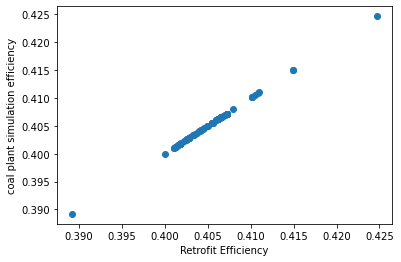

In [233]:
#which ones are the low eff ones? prob have MX issues
plt.scatter(output_TES_df.loc['steam_eff',:],output_TES_df.loc['coal_steam_eff',:])
plt.xlabel('Retrofit Efficiency')
plt.ylabel('coal plant simulation efficiency')

# same efficiencies reached

Text(0, 0.5, 'difference in efficiency')

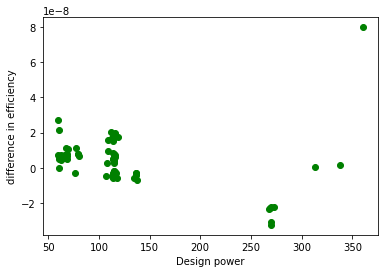

In [234]:
#plt.scatter(inputdata_df.loc['P_out',:],output_TES_df.loc['coal_steam_eff',:])
plt.scatter(output_TES_df.loc['P_out_net',:],output_TES_df.loc['coal_steam_eff',:]-output_TES_df.loc['steam_eff',:],color='green')
#plt.ylim(bottom=0.39)

plt.xlabel('Design power')
plt.ylabel('difference in efficiency')

Text(0, 0.5, 'output power')

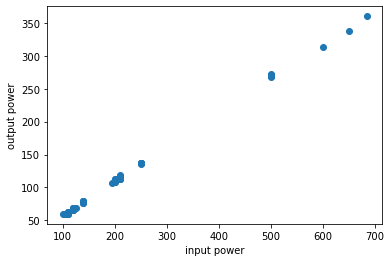

In [235]:
plt.scatter(inputdata_df.loc['P_out',:],output_TES_df.loc['P_out_net',:])
plt.xlabel('input power')
plt.ylabel('output power')
